# Speaker Accent Recognition
## DTSA 5509 Introduction to Machine Learning: Supervised Learning - Final Project
Jupyter Notebook available via GitHub: https://github.com/patsop/DTSA_5509

## Problem Description

The problem at hand consists of detecting the accent of speakers from different countries. We want to evaluate it in a binary sense and differentiate between speakers from the US and from outside the US. We are simplifying the problem in this way to accomodate the relatively low number of samples, which is only 330 in total. Furthermore, by using the dataset in this way we get a perfectly balanced sample. The paper of *Ma et. al 2014*, cited on the UCI Machine Learning Repository, from which the data was obtained, is also using the data in this way.

Moreover, we will use features in the form of mel-frequency clepstral coefficients (MFCC) created from the audio signals of single words spoken in the respective language. In this way we get twelve features per sample, together with the respective label, representing the target language.

The data also contains ten of the original 330 audio signals in a .wav format. We will use these signals to try and implement our own audio signal to MFCC converter. At the end of the paper we will facilitate these manually created MFCCs with their known target value and test our final model against them. Obviously this is not a perfect test for the model as we do not know, how the original MFCCs given were created and can therefore not tell whether our approach is different, but the test should tell us something about the robustness of our model with respect to varying input features. Furthermore, we can test our own implementation of the MFCC converter in this way.

## Exploratory Data Analysis (EDA)

In [26]:
# Used packages

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft
from scipy.fftpack import dct
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

First we perform a train-test-split right at the beginning of the EDA procedure, as we do not want to acquire any insights from the test data.

In [27]:
df = pd.read_csv('./Data/accent-mfcc-data-1.csv')
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:],df.iloc[:,0],train_size=0.8, random_state=42)

We will print the first rows of our training data to give a first impression of the data. As we can see, we have twelve features in the form of MFC-coefficients. Furthermore, we print the unique values of the target vector, which gives us 6 different languages. We will reduce them as mentioned before to the binary case of non-US (0) and US (1).

In [28]:
print(X_train.head())
print(y_train.head())
print(y_train.unique())
y_train = y_train.replace(to_replace=["UK","FR","IT",'GE','ES'],value=0)
y_train = y_train.replace(to_replace="US",value=1)
y_test = y_test.replace(to_replace=["UK","FR","IT",'GE','ES'],value=0)
y_test = y_test.replace(to_replace="US",value=1)
y_train.head()

            X1        X2        X3         X4        X5         X6         X7  \
75    7.266305 -2.226078  1.169851   4.777130 -9.526386  10.532668 -10.750208   
184   3.362900 -5.279764  7.357451   8.326915 -6.115168  10.327969 -10.434079   
17   11.263467 -6.017982 -0.726262  11.959800 -5.667235  12.318475  -7.892121   
24   13.673290 -9.329461 -0.008073   6.951391 -9.590551  12.869720  -9.072661   
180   5.178245 -5.049401  5.980721  10.562531 -8.000220  10.340584 -11.530766   

           X8        X9       X10       X11       X12  
75   5.093525  0.416796 -3.714795  5.202507 -2.365555  
184  6.536561 -0.412717 -4.929815  3.849205 -4.384082  
17   4.131175 -0.672802 -9.215645  4.770874 -0.822530  
24   3.620028 -1.772338 -9.868867  6.307046 -0.387155  
180  5.072530  2.297954 -2.365443  4.622242 -5.539080  
75     GE
184    US
17     ES
24     ES
180    US
Name: language, dtype: object
['GE' 'US' 'ES' 'IT' 'UK' 'FR']


75     0
184    1
17     0
24     0
180    1
Name: language, dtype: int64

As the data already contains the MFC-coefficients, we can first do a simple EDA procedure on these values to get a sense about their distribution.

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 75 to 102
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      263 non-null    float64
 1   X2      263 non-null    float64
 2   X3      263 non-null    float64
 3   X4      263 non-null    float64
 4   X5      263 non-null    float64
 5   X6      263 non-null    float64
 6   X7      263 non-null    float64
 7   X8      263 non-null    float64
 8   X9      263 non-null    float64
 9   X10     263 non-null    float64
 10  X11     263 non-null    float64
 11  X12     263 non-null    float64
dtypes: float64(12)
memory usage: 26.7 KB


We can see, that we do not have any null or invalid values in our dataset, so data cleaning is not necessary.

In [30]:
X_train.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,5.687580,-4.311618,2.646191,7.257310,-5.479592,9.763946,-9.367103,5.167295,-1.363234,-2.401892,2.406548,-3.975738
std,5.218171,3.543259,3.590465,4.426175,4.698028,3.699022,2.472886,2.649083,3.626670,5.210242,3.644491,3.083617
min,-6.067831,-14.972962,-6.186583,-8.844231,-15.656596,-3.162139,-15.365665,-2.873862,-15.510974,-11.429178,-13.664104,-13.724103
25%,2.260022,-6.564809,0.280945,4.590936,-8.328841,8.633162,-11.005685,3.494708,-1.903869,-5.258931,1.177595,-5.974931
50%,4.954206,-4.235071,2.029268,8.153576,-6.726032,10.379330,-9.754247,4.879738,-0.474565,-3.362391,3.214643,-4.384082
75%,9.952738,-1.559928,4.041550,10.459271,-4.222891,11.711488,-7.805470,6.753381,0.613719,-1.661361,4.659480,-2.151659
max,17.749851,3.570765,17.066487,16.178942,7.912809,21.445837,-0.424033,13.846083,4.789989,16.326455,9.166066,5.259430


All instances of all features range between a minimum of about -15 and a maximum of about 22 with varying means and distributions. Because of that we will plot a histogram of all features with binwidth=1  ranging from -15 to 22.

array([<AxesSubplot:title={'center':'X1'}>,
       <AxesSubplot:title={'center':'X2'}>,
       <AxesSubplot:title={'center':'X3'}>,
       <AxesSubplot:title={'center':'X4'}>,
       <AxesSubplot:title={'center':'X5'}>,
       <AxesSubplot:title={'center':'X6'}>,
       <AxesSubplot:title={'center':'X7'}>,
       <AxesSubplot:title={'center':'X8'}>,
       <AxesSubplot:title={'center':'X9'}>,
       <AxesSubplot:title={'center':'X10'}>,
       <AxesSubplot:title={'center':'X11'}>,
       <AxesSubplot:title={'center':'X12'}>], dtype=object)

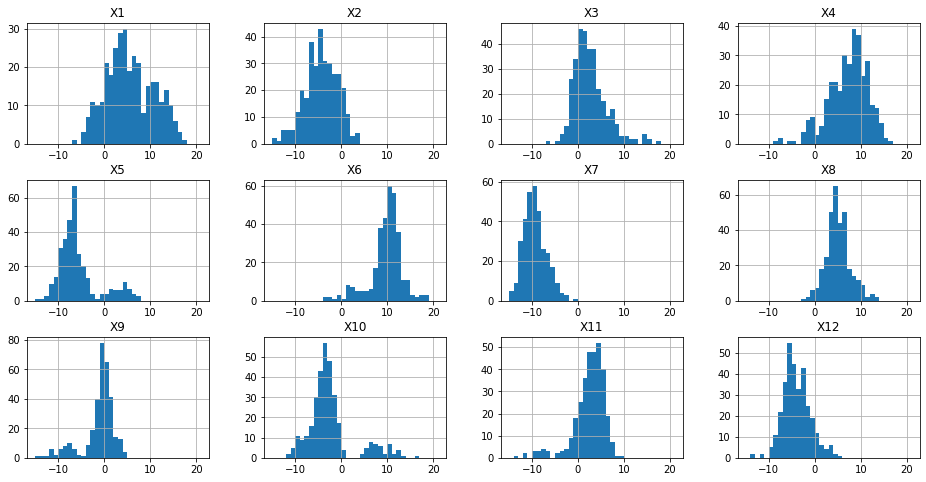

In [31]:
#define format for subplots (1 row and 3 columns)
fig, axis = plt.subplots(3,4,figsize=(16,8))

#create histogram for each column in DataFrame
df.hist(ax=axis,bins=list(range(-15,22,1)))

We see that the different features also have quiet different distributions. All distributions have some similiarity to a normal distribution. However, some have a second smaller peak besides the main peak. Furthermore, the distributions of the feature values strongly vary with repsect to their spread around both their respective mean value and nearest peak.

As we want to understand more about the nature of the MFC-coefficients we will use a .wav signals that was part of  the dataset to build our own MFCC converter. In this way we might find ways to modify the conversion with the aim of improving the later model performance. This could be potentially useful for a future work that is not based on the given MFC-coefficients. 

### MFCC Feature Extraction form .wav Signals

We will try to realize the conversion with the .wav file, which is loaded in the following cell.

In [32]:
samplerate, data = wavfile.read('./Data/ES-M-1-1.wav')

According to the sampling rate of 44.1 kHz and the number of values in the file. We have a sound signal of about 717 ms.

In [33]:
len(data)/samplerate

0.7169160997732427

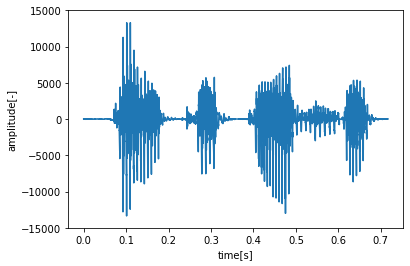

In [34]:
timeseries = []
_ = 0
for i in range(len(data)):
    timeseries.append(_)
    _+=1/samplerate
plt.plot(timeseries,data)
plt.xlabel("time[s]")
plt.ylabel("amplitude[-]")
plt.ylim(-15000,15000)
plt.show()

According to Ma et al. 2014 it is a useful first step to use a pre-emphasis filter on the raw signal (high-pass 1st order). This filter will increase the high frequencies of the signal and respectively realtively reduce the low frequencies. We will choose a filter parameter of 0.95 to get similar results to the cited paper.

In [35]:
data2 = []
for i in range(len(data)):
    if i:
        data2.append(data[i] - 0.95*data[i-1])
    else:
        data2.append(data[i])

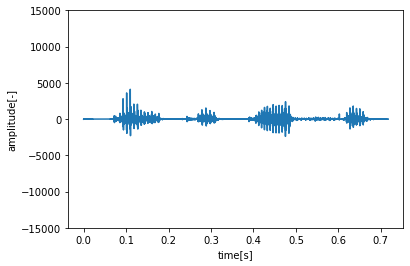

In [36]:
plt.plot(timeseries,data2)
plt.xlabel("time[s]")
plt.ylabel("amplitude[-]")
plt.ylim(-15000,15000)
plt.show()

In the above plots we can see the stark difference between the amplitudes before and after filtering the signal. We will continue with the filtered data.

The next step to complete is the transformation of the signal into the frequency domain. One reason for that is that a time-series signal would have way to much features, around 30000 in our case. We will transform the signal using scipys short term fourier transform (STFT) function. The advantage of the short term fourier transformation is, that it can be used to convert a non-stationary signal into the frequency domain. As we do have such a signal, we will follow this path. The result are multiple single windows of the original signal, that are transformed with the fourier transformation. Following the techniques from Ma et al. 2014 we will use a Hamming window function.

According to Kuldip et al. 2010 a window length between 15 ms and 35 ms constitues an optimum for speech recognition. For simplicity I will use the middle value of this range, which is 25 ms. As we have a sampling frequency of 44.1 kHz, 25 ms is equivalent to a window length of 1102 datapoints. Furthermore, we will use "odd" padding. This describes the way we handle the start and the end of the dataset. Because our window is 1102 datapoints long for the first 651 points the window will include values for time points smaller than zero, were we do not have a recorded signal. "Odd" means that the original signal will be mirrored around the point at zero, which creates a signal mirrored around the time and amplitude axis in the negative time domain. For me this sounds sensible, as I do not want to use "zero" padding, because no speech will contain prolonged silence. Furthermore "even" padding creates a hard border and an unsteady signal that might falsify the frequency conversion.

The overlap of the single windows was choosen according the remarks of Jameslyons 2013 to be 15 ms or 661 sample points.

In [37]:
freq,segtimes,Zxx = stft(data2, samplerate, window='hamming', nperseg=1102, noverlap=661 ,boundary='odd')

In [38]:
print(Zxx.shape)
Zxx

(552, 73)


array([[-1.00023795e+01+0.j        , -4.40294233e-01+0.j        ,
         5.04358415e-02+0.j        , ...,  7.89206477e-02+0.j        ,
        -2.22985336e-01+0.j        ,  3.05486407e-02+0.j        ],
       [ 4.25687975e+00+6.06621174j, -3.48335306e-01+0.45243982j,
         3.08609725e-02-0.21365295j, ..., -3.50429292e-01-0.10720512j,
         1.82279381e-01+0.12140324j,  2.55526871e-03+0.09314034j],
       [-2.37951200e-03-3.48318545j, -3.30672465e-01-0.01979306j,
        -1.13951587e-01+0.16279159j, ...,  5.17136501e-01+0.50210736j,
        -1.20778903e-01-0.08819539j, -2.14966442e-01-0.12230454j],
       ...,
       [-2.37951200e-03-0.4100519j , -1.55721012e-01-0.33444354j,
         1.30604654e-02+0.1410845j , ..., -1.33646486e-01-0.15105574j,
         1.37389948e-01-0.15735941j, -2.92048812e-01+0.10711498j],
       [-2.37951200e-03+0.61972367j, -1.17440608e-01+0.34823565j,
        -8.53955817e-02-0.12108917j, ...,  2.65102794e-01+0.21934062j,
        -1.63676228e-01+0.25729373j

The result of our STFT are the 552 fourier coefficients each for the 73 windows of our signal. We will only keep the first 200 coefficients at the end of the process but calculate the periodogram-based power spectral estimate, which is given by $P=1/N*|S|^2$, for all coefficients first. Were S is the fourier transform of the orginal signal in the current frame and N is the number of datapoints in each frame.

In [39]:
pb_power_spec_est = []
pb_power_spec_est = 1/1102*abs(Zxx**2)
pb_power_spec_est.shape

(552, 73)

As a result we get the periodogram-based power spectral estimate for the coefficients of the STFT of all 73 windows. In our nparray the windows are shown as columns. Next we have to compute the mel-filterbanks, that will be used to calculate the energy of the spectrum for different banks. For higher frequencies the bands get wider, as small differences become less important (Jameslyons 2013). We will start the first bank at 300 Hz and end with 8 kHz, using 26 filter banks, in accordance to the advice in Jameslyons 2013 and calculate the mel-filterbanks in the following. The borders between the banks are only linearly spread with resepect to the Mel-frequency measure in Hertz frequencies the spread is non-linear. This can be infered from the below conversion formula between the two measures.

In [40]:
def f_to_mel(f):
    return(1125*np.log(1+f/700))
def mel_to_f(mel):
    return(700*(np.exp(mel/1125)-1))
# We first calculate the edges of the banks in mel-frequencies
m0 = f_to_mel(300)
mend = f_to_mel(8000)
mels = np.linspace(m0,mend,28) # 28 as we will use a triangular filter for creating the filtered signals in the banks using the point at +1
# Then we transform them back to the "normal" frequencies to get the edges of the banks in Hertz
mels = mel_to_f(mels)
print(mels)
# In our STFTs the nearest frequencies fitting to the bank edges will be calculated in the following.
stft_i = np.floor((1102+1)*mels/samplerate)
#print(stft_i)
print([freq[int(i)] for i in stft_i])

[ 300.          383.42040146  473.7997663   571.71861405  677.80589138
  792.74301197  917.26823331 1052.18139861 1198.34907431 1356.71011621
 1528.28169979 1714.16585376 1915.55653848 2133.74731496 2370.13965362
 2626.25193607 2903.72920794 3204.35374523 3530.0565021  3882.92951372
 4265.23933362 4679.44159219 5128.19676945 5614.38728376 6141.13600596
 6711.82631804 7330.12384505 8000.        ]
[280.1270417422867, 360.1633393829401, 440.19963702359337, 560.2540834845734, 640.2903811252268, 760.3448275862067, 880.3992740471867, 1040.4718693284935, 1160.5263157894735, 1320.59891107078, 1520.6896551724135, 1680.7622504537203, 1880.8529945553537, 2120.9618874773137, 2361.0707803992736, 2601.1796733212336, 2881.3067150635206, 3201.451905626134, 3521.597096188747, 3881.760435571687, 4241.923774954627, 4682.12341197822, 5122.323049001814, 5602.540834845734, 6122.776769509981, 6683.030852994554, 7323.321234119781, 8003.629764065335]


In contrast to Jameslyons 2013 we will only use the first 200 coefficients of our STFT, as our audio signal was recorded with 44.1 kHz instead of 16 kHz and the STFTs consist of more points each. Lets plot our 26 mel-filterbanks.

(26, 201)


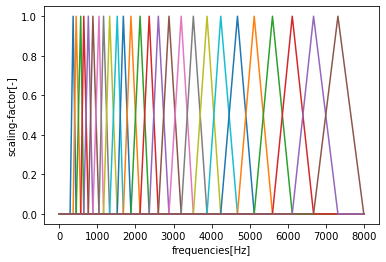

In [41]:
def triangular_filter(k,m,stft_i):
    if k<stft_i[m-1]:
        return(0)
    elif stft_i[m-1]<=k<=stft_i[m]:
        return((k-stft_i[m-1])/(stft_i[m]-stft_i[m-1]))
    elif stft_i[m]<=k<=stft_i[m+1]:
        return((stft_i[m+1]-k)/(stft_i[m+1]-stft_i[m]))
    elif k>stft_i[m+1]:
        return(0)


def get_filter_functions(stft_i):
    filters = []
    for m in range(1,27):
        filters.append([triangular_filter(k,m,stft_i) for k in range(int(stft_i[-1]+1))])
    return(np.array(filters))

filters = get_filter_functions(stft_i)
print(filters.shape)
for line in range(filters.shape[0]):
    plt.plot([freq[i] for i in range(int(stft_i[-1]+1))],filters[line,:])
    plt.xlabel('frequencies[Hz]')
    plt.ylabel('scaling-factor[-]')

Now we can utilize the scaling factors from the filter to individually weigh the STFT coefficients power spectrum estimate for each bank. This results in 26 values per window describing the energy of the signal in different frequency ranges. Later the log of these energies will be taken, which is the standard approach and after doing a final discrete cosine transform we just have to keep the first 12 coefficients, as this fits the approach taken in the creation of our available data.

In [42]:
m_f_cep_coeff = np.log(filters@pb_power_spec_est[:201,:]).T
m_f_cep_coeff.shape

(73, 26)

In [43]:
m_f_cep_coeff = dct(m_f_cep_coeff,axis=1)
print(m_f_cep_coeff.shape)
m_f_cep_coeff = m_f_cep_coeff[:,:12]
print(m_f_cep_coeff.shape)

(73, 26)
(73, 12)


Ma et al. 2014 suppose to just take the mean of the MFCCs for each window as a model input, which we will replicate for sake of simplicity. This gives us the following twelve coefficients for our original audio signal.

In [44]:
m_f_cep_coeff_mean = np.mean(m_f_cep_coeff,axis=0)
m_f_cep_coeff_mean

array([-2.23250429e+02,  4.97136009e-01, -1.74078068e+01,  1.42012496e+01,
        1.29681167e+01,  1.22081151e+01, -2.09078674e-01,  9.69206527e+00,
       -1.15339383e+01,  2.81836641e+00, -3.83083552e+00,  2.98118463e+00])

We can see that our data seems to be on a different scale regarding the coeffcients as the original data. This is of small wonder, as a lot of assumptions and mulitple possible paths for the MFCC creation process lead to our final solution. Nevertheless, this was a valuable EDA procedure for me, as I got to understand the data a lot better and can now clearly describe, what the coeffcients mean and which later operations in the model building on them are reasonable. Despite the fact, that the scales seem to differ I will just try to plug in the values in the end of this work into my final model and see what happens. Maybe the first impression of differing scales is deceptive.

## Model Building and Training with Parameter Optimization

We will test the performance of three different types of machine learning models on the original dataset. In detail this will be a random forest classifier, a support vector classifier and a k-nearest neighbors classifier.

### Random Forest Classifier

The random forest classifier combines multiple decision trees into one predictive model. The criterion for the single splits in the individual decision trees is either the gini coefficient or entropy based. Furthermore the decisions trees have a max depth between 3 and 7 in our grid search for the optimal model parameters. Decision trees get their predicitve power by two major machanisms. First of all it uses bootstrapping to learn the single decision trees on different subsets of the original training data. Furthermore, a random forest is called random as the selection of the features that may be used for the single splits inside the trees is a random subset of all features. In our case every split uses the square-root of the amount of total features available. Combined with the 5-fold cross validation procedure that uses differing subsets of all the train data to learn and test the model, we hope to acquire the optimal solution for this classifier.

In [45]:
rvc = RandomForestClassifier(n_jobs=-1,random_state=42)
params = {
    'n_estimators':[10,100,150,175,1000],
    'criterion':['gini','entropy'],
    'max_depth':[3,4,5,6,7,8,10]
}
rfc_grid = GridSearchCV(rvc, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5,return_train_score=True)
rfc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 10],
                         'n_estimators': [10, 100, 150, 175, 1000]},
             return_train_score=True, scoring='accuracy')

In [46]:
print(rfc_grid.best_score_)
print(rfc_grid.best_params_)
#print(rfc_grid.cv_results_['mean_train_score'])
#print(rfc_grid.best_estimator_.feature_importances_)
np.argsort(rfc_grid.best_estimator_.feature_importances_)[-2:]

0.8288098693759072
{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 1000}


array([8, 9])

According to the impurity based feature importance of the random forest classifier the features X9 and X10 have the highest importance for descerning between US and non-us speakers.

The best random forest classifier reaches a test validation score of 0.83 and uses the following parameters:
- Split criterion: Gini
- Maximum depth of the decision tree stumps: 8
- Number of decision tree stumps: 1000

In the following diagrams we can see how the cross-validated training and test scores evolved with differing input parmeters one by one. We will always choose the optimal parameter for all but one category and compare all checked possiblities for the remaining category.

In [47]:
def plot_opt_evolution(param_fix, param_vary, cv_results):
    # list of parameters fixed with optimal value as tuple, parameter varied, cv_results
    ids= []
    x = []
    for i in range(len(cv_results['params'])):
        if param_fix:
            if cv_results['params'][i][param_fix[0][0]] == param_fix[0][1] and cv_results['params'][i][param_fix[1][0]] == param_fix[1][1]:
                ids.append(i)
                x.append(cv_results['params'][i][param_vary])
        else:
            ids.append(i)
            x.append(cv_results['params'][i][param_vary])            
    train_score = [cv_results['mean_train_score'][i] for i in ids] 
    test_score = [cv_results['mean_test_score'][i] for i in ids]

    
    plt.plot(x,train_score,label='Train')
    plt.plot(x,test_score,label='Test')
    plt.legend()
    plt.xlabel(param_vary)
    plt.ylabel('accuracy')
    plt.title('Optimization Evolution Parameter: '+param_vary)
    plt.show()

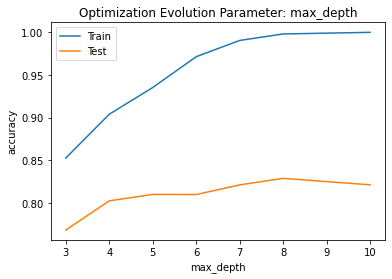

In [48]:
plot_opt_evolution([('criterion','gini'),('n_estimators',1000)],'max_depth',rfc_grid.cv_results_)

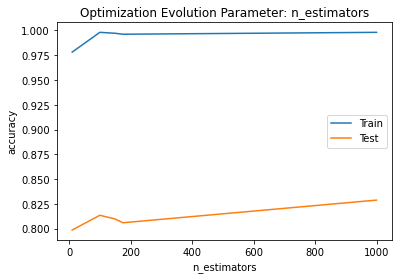

In [49]:
plt.clf()
plot_opt_evolution([('criterion','gini'),('max_depth',8)],'n_estimators',rfc_grid.cv_results_)

We see that the model improves with increasing number of estimators, regarding the test data. The advantage is small but we will nevertheless choose the maximum tested number of 1000 estimators. We will not test or use higher numbers as this would strongly increase the computational complexity, which could be a problem for bigger training datasets. Furthermore, using too much estimators per sample does not feel right. Next we will compare the results of a support vector classifier with the ones acquired here with the random forest.

### Support Vector Classifier (SVC)

The SVC uses multi-dimensional and possibly comlex decision boundaries to part the multi-dimensional feature space into two areas, which will in turn allow the model to differentitate between US and non-US speakers.

In [50]:
svc = SVC(random_state=42)
params = {
    'C':[0.01,0.1,1,10,25,50,100],
    'kernel':['linear','poly','rbf'],
    'degree':[2,3,4,5]
}
svc_grid = GridSearchCV(svc, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5,return_train_score=True)
svc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 25, 50, 100],
                         'degree': [2, 3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True, scoring='accuracy')

In [51]:
print(svc_grid.best_score_)
print(svc_grid.best_params_)

0.8631349782293178
{'C': 25, 'degree': 4, 'kernel': 'poly'}


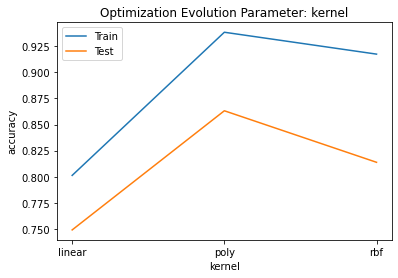

In [52]:
plot_opt_evolution([('C',25),('degree',4)],'kernel',svc_grid.cv_results_)

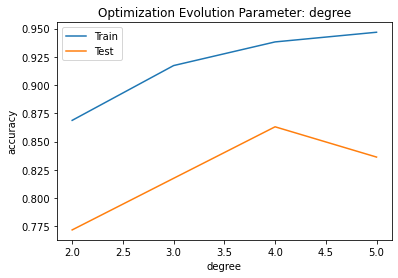

In [53]:
plot_opt_evolution([('kernel','poly'),('C',25)],'degree',svc_grid.cv_results_)

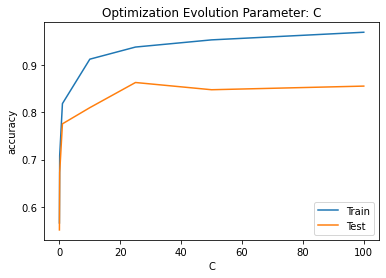

In [55]:
plot_opt_evolution([('degree',4),('kernel','poly')],'C',svc_grid.cv_results_)

We see that the polynomial kernel autperforms both the linear and the rbf kernel. From the polynomial kernels the one with four degrees of freedom performs best. Furthermore we see, that a regularization parameter of 25 delivers the best results. It determines the balance between correct classification and variance of the decision boundary. In combination the following parameters perform the best.

- C: 25
- Kernel: Polynomial
- Degree: 4

### K-nearest Neighbor Classifier (KNN)

Now we will try to use a simple KNN classifier, which labels the unknown data according to the known labels of the nearest k samples. This approach runs into problems for large amounts of data, as the algorithm has to use all the data at once in the memory. This is not a problem in our case as we have very little data. However, we have to take this in mind, as it would limit us while trying to improve our model performance with significantly more training data.

In [56]:
knn = KNN(n_jobs=-1)
params = {
    'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
}
knn_grid = GridSearchCV(knn, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5,return_train_score=True)
knn_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='accuracy')

In [57]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)

0.8518142235123367
{'n_neighbors': 3}


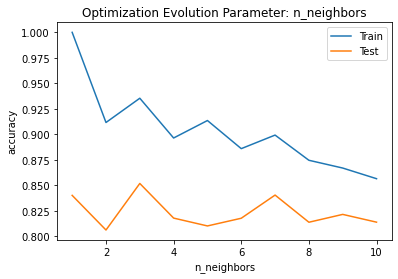

In [58]:
plot_opt_evolution(False,'n_neighbors',knn_grid.cv_results_)

The KNN classifier only considering three neighbors delivers the best result. The result for both training and test sets of the cross validation procedure decreases from then on with increasing number of neighbors.

Finally we will test a multiple linear regression model (MLR), using the most important features from the evaluation of the random forest classifier as an input. The output of the MLR-model is transformed by a logit link function to accomodate the binary nature of the output. In comparion to the above mentioned ML-algorithms the MLR model has the advantage, that the results and the impacts of the single input parameters are easily explainable and not produced by kind of a black box algorithm.

### MLR

In [59]:
lr = LogisticRegression(random_state=42,n_jobs=-1)
lr.fit(X_train.iloc[:,8:10],y_train)
lr_grid = cross_validate(knn, X_train.iloc[:,8:10], y_train, scoring='accuracy', n_jobs=-1, cv=5,return_train_score=True)

In [60]:
lr_grid['test_score'].mean()

0.6959361393323658

When compared to the more complex models, the very basic logistic regression model with only two input features performs poorly. Increasing the amount of input features would surely improve the performance, however at the cost of explainability and simplicity, which were the only reasons to initialy test this simple model.

## Results, Discussion and Conclusion

In this section we will test the best models from each type according to the cross validaton procedures with our test-data to reach a final verdict about the best overall model and its performance. We will test each model, as non, besides the LR-model, was clearly inferior the the others during the cross-validation procedure.

In [62]:
pred = rfc_grid.best_estimator_.predict(X_test)
print('RFC: ',accuracy_score(y_test,pred))

pred = svc_grid.best_estimator_.predict(X_test)
print('SVC: ',accuracy_score(y_test,pred))

pred = lr.predict(X_test.iloc[:,8:10])
print('LR: ',accuracy_score(y_test,pred))

pred = knn_grid.best_estimator_.predict(X_test)
print('KNN: ',accuracy_score(y_test,pred))

RFC:  0.8939393939393939
SVC:  0.8484848484848485
LR:  0.5909090909090909
KNN:  0.8939393939393939


The Random Forest and the KNN Classifier perform equally with a accuracy score of around 90%. The Logistic Regression approach is only about as accurate as a random guess and the support vector classifier performs a little bit less good than the best models with an accuracy of 85%. So the generalization capabilities of the KNN classifier and the Random Forest seem to the best for all tested models. We will select the KNN classifier to be our final model, because it is a simpler model, and further check the confusion matrix on the test data to get a sense of the types of wrong predictions.

In [63]:
confusion_matrix(y_test,pred,labels=[0,1])

array([[31,  2],
       [ 5, 28]])

We see that we only got two false negatives in 66 total instances, which means that only two speakers were wrongly classified as being not from the US. However, 5 speakers were classified as being from the US, where in fact they were not. So our model is nearly perfect when we want to make sure that no one will be called a non-US speaker when he or she in fact is.

Finally we can say, that a very simple model (KNN with one three neighbors) delivered quite good results on the dataset at hand. This shows that we should always carefully weigh the pros and cons for specific approaches and test different solutions for prediction tasks. Lets's at last test the input data for the one instance created by our own MFCC creation process from the first section and give it a try with the KNN-model.

In [64]:
knn_grid.best_estimator_.predict(m_f_cep_coeff_mean.reshape(1,-1))

array([0])

As we only have a limited amount of original .wav files (10) we are not able to surely say if our own MFCC process delivers valid input for the KNN-classifier, however in this specific instance the answer of the classifier was correct. The voice recording is from a non-US speaker. This result is of no scientifc value, but it was fun and interesting to perform the MFCC creation process by myself, understanding the details and give it a try on the final model.

For future work a bigger dataset, as well as .wav files for each instance, would be extremely helpful, as this would enbale us to fully use our very-own MFCC creation process and would make the differences between the single models, tested, more finely nuanced. Furthermore, if we would have more data in the future we might switch our choosen model to the equally good Random Forest Classifier, as our KNN approach would surely run into memory constraints at a specific point.

## References

Ma et al. 2014: Ma, Z.C. and Fokoué, E. (2014) A Comparison of Classifiers in Performing Speaker Accent Recognition Using MFCCs. Open Journal of Statistics, 4, 258-266. http://dx.doi.org/10.4236/ojs.2014.44025

Fokoué 2020: UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science

Jameslyons 2013: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

Kuldip et al. 2010: Kuldip K. Paliwal, James G. Lyons and Kamil K. Wojcicki, Preference for 20-40 ms window duration in speech analysis, IEEE

sklearn Documentation


## Documentation of Packages

In [78]:
conda list

# packages in environment at /opt/anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py38_0  
alabaster                 0.7.12             pyhd3eb1b0_0  
altair                    4.2.2              pyhd8ed1ab_0    conda-forge
anaconda                  2021.05                  py38_0  
anaconda-client           1.7.2                    py38_0  
anaconda-navigator        2.3.2            py38hecd8cb5_0  
anaconda-project          0.9.1              pyhd3eb1b0_1  
anyio                     2.2.0            py38hecd8cb5_1  
appdirs                   1.4.4                      py_0  
applaunchservices         0.2.1                      py_0  
appnope                   0.1.2           py38hecd8cb5_1001  
appscript                 1.1.2            py38h9ed2024_0  
argh                      0.26.2                   py38_0  
argon2-cffi               20.1.0           py38h9ed2024_1  
asn1crypto                1.4.0


Note: you may need to restart the kernel to use updated packages.
